
🚀 訓練模型（Activation: sigmoid）
⏱ 訓練時間: 16.98 秒, MAE: 3.430, RMSE: 4.716, MAPE: 16.56%

🚀 訓練模型（Activation: softplus）
⏱ 訓練時間: 15.49 秒, MAE: 2.843, RMSE: 4.516, MAPE: 14.92%

🚀 訓練模型（Activation: relu）
⏱ 訓練時間: 15.52 秒, MAE: 2.785, RMSE: 4.491, MAPE: 14.38%


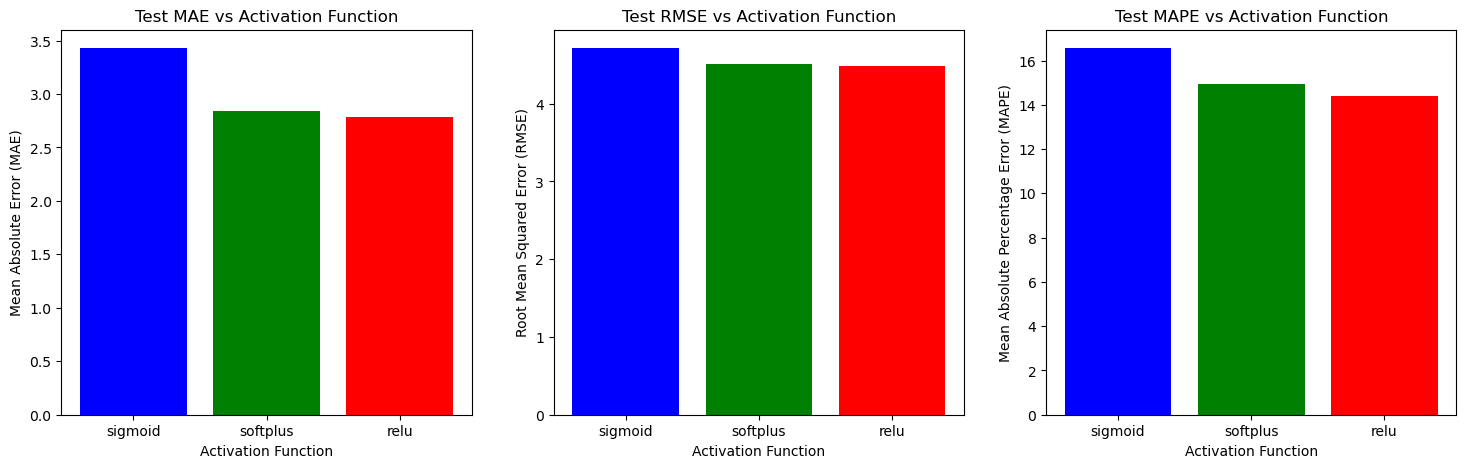

In [8]:
# 匯入必要的函式庫
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop

# 1️⃣ 載入 Boston Housing 數據集
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# 2️⃣ 數據標準化（Z-score normalization）
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

# 3️⃣ 定義 RMSE 和 MAPE 計算函數
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 4️⃣ 建立神經網路模型（不同激活函數）
def build_model(activation='relu'):
    model = Sequential()
    model.add(Input(shape=(train_data.shape[1],)))  # 🔹 使用 Input() 定義輸入層
    model.add(Dense(64, activation=activation))  # 隱藏層，使用不同的激活函數
    model.add(Dense(1))  # 輸出層（迴歸問題）

    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])  # 🔹 使用 MAE 作為評估指標
    
    return model

# 5️⃣ 設定不同的激活函數
activations = ['sigmoid', 'softplus', 'relu']
results_dict = {}
model_dict = {activation: build_model(activation=activation) for activation in activations}  # ✅ 在迴圈外建立模型

# 6️⃣ @tf.function 避免 retracing
@tf.function(reduce_retracing=True)
def my_predict(model, data):
    return model(data)

# 7️⃣ 訓練不同激活函數的模型
for activation in activations:
    print(f"\n🚀 訓練模型（Activation: {activation}）")
    model = model_dict[activation]  # 直接使用預先建立的模型

    # 記錄訓練時間
    start_time = time.time()
    
    # 訓練模型
    history = model.fit(train_data, train_targets, 
                        epochs=100, batch_size=16, 
                        validation_data=(test_data, test_targets),
                        verbose=0)
    
    training_time = time.time() - start_time  # 計算訓練時間

    # **避免 retracing，使用 my_predict() 或 predict_on_batch()**
    predictions = model.predict_on_batch(test_data).flatten()

    # 計算 MAE、RMSE、MAPE
    test_mae = np.mean(np.abs(test_targets - predictions))
    test_rmse = rmse(test_targets, predictions)
    test_mape = mape(test_targets, predictions)

    # 儲存結果
    results_dict[activation] = {"MAE": test_mae, "RMSE": test_rmse, "MAPE": test_mape}
    print(f"⏱ 訓練時間: {training_time:.2f} 秒, MAE: {test_mae:.3f}, RMSE: {test_rmse:.3f}, MAPE: {test_mape:.2f}%")

# 8️⃣ 視覺化結果：繪製 MAE、RMSE、MAPE 圖表
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 📌 MAE 圖表
mae_values = [results_dict[act]['MAE'] for act in activations]
axes[0].bar(activations, mae_values, color=['blue', 'green', 'red'])
axes[0].set_title("Test MAE vs Activation Function")
axes[0].set_xlabel("Activation Function")
axes[0].set_ylabel("Mean Absolute Error (MAE)")

# 📌 RMSE 圖表
rmse_values = [results_dict[act]['RMSE'] for act in activations]
axes[1].bar(activations, rmse_values, color=['blue', 'green', 'red'])
axes[1].set_title("Test RMSE vs Activation Function")
axes[1].set_xlabel("Activation Function")
axes[1].set_ylabel("Root Mean Squared Error (RMSE)")

# 📌 MAPE 圖表
mape_values = [results_dict[act]['MAPE'] for act in activations]
axes[2].bar(activations, mape_values, color=['blue', 'green', 'red'])
axes[2].set_title("Test MAPE vs Activation Function")
axes[2].set_xlabel("Activation Function")
axes[2].set_ylabel("Mean Absolute Percentage Error (MAPE)")

plt.show()
